<a href="https://colab.research.google.com/github/pateljay7018/CE888-7-SP-D.S.-and-decision-making-/blob/main/Lab-4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages/libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the data files

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)

In [ ]:
test_data=pd.DataFrame(data)
test_data=pd.concat([test_data.loc[:, 0], test_data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
test_data.drop(columns=[0], inplace=True)

In [ ]:
data=pd.concat([data.loc[:, 0], data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
data.drop(columns=[0], inplace=True)

In [ ]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
# val_data.head()

# Highest and lowest rated joke

In [ ]:
print('Joke with highest rating : ', test_data.max(axis=0).idxmax())
print('Joke with lowest rating : ', test_data.min(axis=0).idxmin())

Joke with highest rating :  45
Joke with lowest rating :  1


In [ ]:
# val_data=pd.DataFrame(data)
# val_data.drop(columns=[0], inplace=True)

# Prepare Validation Data

In [ ]:
arr = val_data.values
arr.shape

(24983, 100)

In [ ]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [ ]:
# data.drop(columns=[0], inplace=True)

In [ ]:
len(np.where(arr!=99)[1])

1810455

In [ ]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [ ]:
new_arr, idx = replace(arr, 0.1)

In [ ]:
arr[idx[0][0], idx[1][0]]

-4.76

In [ ]:
new_arr[idx[0][0], idx[1][0]]

99.0

In [ ]:
val_data=pd.DataFrame(new_arr)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))
val_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,NaN,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.4,-8.40,-8.40,...,8.59,3.59,NaN,-9.03,2.82,NaN,-9.08,NaN,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,NaN,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.4,-0.87,7.91,...,-6.70,-3.35,NaN,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,NaN,NaN,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,NaN,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,NaN,9.37,6.17,NaN,-6.89,NaN,9.03,NaN,9.03,7.28,NaN,8.25,NaN,NaN,NaN,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,NaN,9.08,NaN,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,NaN,NaN,6.21,NaN,1.84,NaN,NaN,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,NaN,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.3,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,4.61,-4.17,-5.39,NaN,1.60,NaN,NaN,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,NaN,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.8,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,NaN,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,NaN,3.93,NaN,6.31,4.71,2.82,2.96,5.19,5.58,NaN,5.19,5.73,NaN,3.11,6.55,NaN,1.60


# Training

In [ ]:
n_latent_factors = 2

user_ratings = data.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [ ]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 2) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [ ]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/10:	MSE=26.142418
Iteration 2/10:	MSE=24.904724
Iteration 4/10:	MSE=24.434833
Iteration 6/10:	MSE=23.960496
Iteration 8/10:	MSE=23.483579


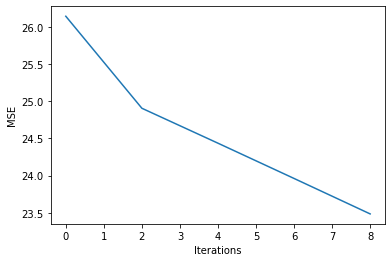

In [ ]:
plt.figure()
plt.plot(np.arange(0, num_iter, 2), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

# Predicting

In [ ]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.72410868, 1.13047476, 1.09513096, ..., 1.99135405, 0.88248876,
        2.64809921],
       [1.00912717, 0.66749716, 0.67130644, ..., 1.1895625 , 0.47152638,
        1.57058208],
       [1.32441545, 0.86398881, 0.81828608, ..., 1.51151777, 0.71198453,
        2.01856902],
       ...,
       [0.78169045, 0.51800738, 0.52495451, ..., 0.92537733, 0.35791288,
        1.21997212],
       [1.43460328, 0.94473732, 0.93251371, ..., 1.67382218, 0.70273651,
        2.21792103],
       [1.90712551, 1.25642688, 1.24235024, ..., 2.22726759, 0.93020838,
        2.95027944]])

# Predicting on Validation set

In [ ]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))

v_data=pd.DataFrame(new_arr)
v_data=pd.DataFrame(v_data.loc[:, 0:].replace(99.00, np.NaN))

v_user_ratings=v_data.values

v_values = [zip(v_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
v_comparison_data = pd.DataFrame(v_values)
v_comparison_data.columns = data.columns

# v_comparison_data

In [ ]:
val_user_ratings=val_data.values

error = []

for user_id in range(latent_user_preferences.shape[0]):
    for item_id in range(latent_item_features.shape[0]):
        rating = val_user_ratings[user_id, item_id]
        
        if not np.isnan(rating):
             val_predicted_rating = predict_rating(user_id, item_id)
             err =  val_predicted_rating - rating
             
            #  err = train(user_id, item_id, rating)
             error.append(err)
val_mse = (np.array(error) ** 2).mean()
print('MSE on Validation Set :', val_mse)

MSE on Validation Set : 23.118021959107747


# Predicting on Test Set

In [ ]:
test_user_ratings=test_data.values
values = [zip(test_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 1.7241086825615308)","(8.79, 1.1304747579341843)","(-9.66, 1.0951309562073785)","(-8.16, -0.9352467762216709)","(-7.52, 1.1773634899737366)","(-8.5, 2.9512815954293634)","(-9.85, 0.01003009107611799)","(4.17, -0.4594822988797396)","(-8.98, 0.010011903633755127)","(-4.76, 2.1459072434291118)","(-8.5, 3.1171210994692977)","(-6.75, 2.89094783579484)","(-7.18, -1.7971575427126356)","(8.45, 2.8770056072150054)","(-7.18, -1.9228256393044252)","(-7.52, -3.590150840538983)","(-7.43, -0.8537611574333859)","(-9.81, -0.3965315245061181)","(-9.85, 0.8374845082265647)","(-9.85, -0.493671139511485)","(-9.37, 3.6897931924071723)","(1.5, 2.006357264116636)","(-4.37, 0.9225091817741915)","(-9.81, -1.4026386779904436)","(-8.5, 1.4330351328519775)","(1.12, 2.6895294881522402)","(7.82, 4.769901271768761)","(2.86, 2.866437007776641)","(9.13, 4.523683130811355)","(-7.43, 0.41972759572448975)","(2.14, 3.749241322775526)","(-4.08, 4.756957422262276)","(-9.08, -0.817737910728849)","(7.82, 2.1834028979904234)","(5.05, 4.627955457319278)","(4.95, 4.8395345133820475)","(-9.17, -1.020455880021275)","(-8.4, 2.3975263219255103)","(-8.4, 2.4198360516832795)","(-8.4, 2.2654483107909464)",...,"(8.59, 4.081862519650477)","(3.59, 4.589380529433961)","(-6.84, 1.2768469486711203)","(-9.03, -0.10137428069590126)","(2.82, 3.8863638439361896)","(-1.36, 4.093821584993361)","(-9.08, -0.24777183119800336)","(8.3, 4.166739533435015)","(5.68, 4.2003737176085085)","(-4.81, 1.5677421225305272)","(nan, -0.0336908928143126)","(nan, 4.228407665298275)","(nan, 2.3587623582872257)","(nan, -0.909934817402934)","(nan, 0.5297977100153045)","(nan, 3.83883101459222)","(nan, 1.8578193566590344)","(-9.42, 3.115210353074567)","(nan, 1.1748162129838466)","(nan, 2.5335994675507054)","(nan, 3.132624727548426)","(-7.72, 1.901500433328544)","(nan, 3.4452749751439176)","(nan, 1.7243936806229219)","(nan, 2.113624676117227)","(nan, 1.0349463350099946)","(nan, 3.110808791837325)","(nan, 3.3258969651914234)","(nan, 5.014258201246667)","(nan, 1.6730460495235802)","(2.82, 3.1839728921079358)","(nan, 2.351213276425965)","(nan, 3.824755496387667)","(nan, 2.1372381814311714)","(nan, 2.0432540148392198)","(nan, 2.619784483606916)","(-5.63, 2.8123292246626885)","(nan, 1.9913540526394367)","(nan, 0.8824887566090591)","(nan, 2.6480992093989126)"
1,"(4.08, 1.0091271677055602)","(-0.29, 0.6674971559568534)","(6.36, 0.6713064353932493)","(4.37, -0.5355865316431272)","(-2.38, 0.6822059310770208)","(-9.66, 1.6901020227627723)","(-0.73, 0.010124721381059262)","(-5.34, -0.2719884723943856)","(8.88, -0.022472098442620485)","(9.22, 1.2687190347511854)","(6.75, 1.8204732464505982)","(8.64, 1.686225054290702)","(4.42, -1.081243145971238)","(7.43, 1.6684700575455034)","(4.56, -1.1261996258212619)","(-0.97, -2.110734650580729)","(4.66, -0.5086584577940384)","(-0.68, -0.23567618040523533)","(3.3, 0.4971575507736708)","(-1.21, -0.27854867920303855)","(0.87, 2.1407836194400773)","(8.64, 1.161132872438477)","(8.35, 0.53987455860713)","(9.17, -0.8400413126144008)","(0.05, 0.8511663942643416)","(7.57, 1.5542628695898637)","(4.71, 2.8029146711865813)","(0.87, 1.6207133459080882)","(-0.39, 2.639295688749255)","(6.99, 0.2272682438624366)","(6.5, 2.178333356068188)","(-0.92, 2.764784944863415)","(7.14, -0.4482888024844567)","(9.03, 1.2527243067463496)","(-1.8, 2.6991284525055246)","(0.73, 2.8178358584310335)","(7.09, -0.5991296441275791)","(3.4, 1.3781249898385097)","(-0.87, 1.4030504424935317)","(7.91, 1.305721011334068)",...,"(-6.7, 2.3572502528650294)","(-3.35, 2.6604629869867202)","(-9.03, 0.7019512245715274)","(4.47, -0.06672418339733739)","(4.08, 2.257312814757474)","(-3.83, 2.3748635527802713)","(8.74, -0.19475650046702056)","(1.12, 2.4310875143080373)","(0.78, 2.44720545568608

In [ ]:
# while 1: pass

# For Quiz

In [ ]:
quiz_users = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Users')
quiz_items = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Items')

In [ ]:
# quiz_movies

In [ ]:
test_data.loc[8243, 61]

-1.02

In [ ]:
comparison_data.loc[8243, 61]

(-1.02, 3.6386506882686147)

In [ ]:
comparison_data.loc[23437, 58]

(nan, -3.7157774766806337)

In [ ]:
quiz_users.loc[quiz_users['User']==4327, 'Factor14']

21   -0.09349
Name: Factor14, dtype: float64

In [ ]:
round(-0.09349, 3)

-0.093

In [ ]:
quiz_items.loc[quiz_items['Movie ID']==629, 'Factor12']

53    0.452338
Name: Factor12, dtype: float64

In [ ]:
(quiz_items.loc[quiz_items['Factor5']==np.max(quiz_items['Factor5']), ['Movie ID', 'Factor5']])

,Movie ID,Factor5
15,121,2.750878


In [ ]:
quiz_items.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [ ]:
np.argmin(quiz_items.loc[:, 'Factor3'].values)

47

In [ ]:
quiz_items.loc[47, ['Title', 'Factor3']]

Title      Titanic (1997)
Factor3          -2.52338
Name: 47, dtype: object

In [ ]:
a=quiz_items.loc[quiz_items['Movie ID']==680]

In [ ]:
a=a.values.squeeze()

In [ ]:
a=a[2:]
a

array([-2.3827392477100444, 2.085395388462736, 0.683163859129389,
       -0.8413931398162213, -0.062048815712846456, 0.32606256907923137,
       0.6249807034681429, 1.0716252740536079, -0.03782040288565136,
       -0.7297955075135498, 0.4125435112858254, -0.033414557487240634,
       0.06267091882517746, 0.22891022325813315, -1.8338999569970884],
      dtype=object)

In [ ]:
b=quiz_users.loc[quiz_users['User']==525]

In [ ]:
b=b.values.squeeze()

In [ ]:
b=b[1:]
b

array([-0.04029047,  0.01438336, -0.09896682, -0.0189566 ,  0.0123881 ,
        0.03554635,  0.00090304,  0.01283525, -0.02108043,  0.018742  ,
       -0.05048254, -0.02539382,  0.03407865,  0.03833042, -0.00134082])

In [ ]:
quiz_pred=np.dot(b, a.T)

In [ ]:
round(quiz_pred, 2)

0.08

In [ ]:
c=quiz_items.loc[quiz_items['Movie ID']==812]
c=c.values.squeeze()
c=c[2:]
c

array([0.9444072873203204, -0.17405053859224534, 0.12318628233184109,
       2.2243105344641236, -0.5695513857263874, 0.018065057433469225,
       0.3010679396871695, 0.03472533646290326, -0.20630092072921338,
       0.5333225541299694, -0.8823041399125704, -0.4469824426741521,
       1.3020155376267466, 0.8368295247444454, -0.46760653696757254],
      dtype=object)

In [ ]:
quiz_pred=np.dot(b, c.T)
round(quiz_pred, 2)

-0.13

In [ ]:
u_2067=quiz_users.loc[quiz_users['User']==3806]
u_2067=u_2067.values.squeeze()
u_2067=u_2067[1:]
u_2067

array([-0.04234433, -0.04075545, -0.05571989, -0.07372552,  0.01820304,
        0.09194021,  0.12395867, -0.1574026 , -0.02038777,  0.08249335,
        0.22305742, -0.04091509, -0.1303082 , -0.02181588,  0.03454886])

In [ ]:
all_item_factors=quiz_items.values[:, 2:]

In [ ]:
quiz_ratings=np.dot(u_2067, all_item_factors.T)

In [ ]:
np.argmax(quiz_ratings)

50

In [ ]:
np.argsort(quiz_ratings)[::-1][:2]

array([50, 68])

In [ ]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:3], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
50,603,The Matrix (1999),-3.063639,-1.319283,-0.043618,-0.994612,-0.954054,0.190838,0.197918,-0.093962,-1.082840,-0.003843,1.377453,-1.668189,-1.348377,0.223797,0.752413
68,854,The Mask (1994),2.263142,-0.067761,-0.205463,0.068880,-0.189090,2.078554,2.444922,-0.075971,-0.674767,-0.198560,1.641380,-0.839276,-0.517086,-1.058431,-0.931746
51,604,The Matrix Reloaded (2003),0.503414,-2.004450,0.001084,-2.255945,0.882547,-0.188600,-0.235434,0.570028,-3.492897,-0.312214,0.902742,-2.063318,-1.895101,0.748458,2.120907


In [ ]:
u_4940=quiz_users.loc[quiz_users['User']==2067]
u_4940=u_4940.values.squeeze()
u_4940=u_4940[1:]
u_4940

array([-8.32419876e-02,  1.81170624e-01, -3.44267114e-01, -1.97126297e-02,
       -2.43198543e-01,  3.92197164e-02, -9.20858062e-02,  1.14807987e-01,
       -3.64718778e-02,  4.23861148e-02, -1.86812335e-01, -1.27038258e-01,
        1.76660761e-01, -5.58122216e-02, -4.16354710e-05])

In [ ]:
quiz_ratings=np.dot(u_4940, all_item_factors.T)
np.argsort(quiz_ratings)[::-1][:3]

array([ 2, 10, 33])

In [ ]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:3], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
10,98,Gladiator (2000),-1.364852,-1.304136,-1.941623,-0.661007,0.128877,0.007048,0.371097,0.086026,-0.133839,0.548053,-0.827216,0.141476,0.735983,-0.338100,-0.175565
33,278,The Shawshank Redemption (1994),-2.780308,-0.088747,-1.821590,-0.157495,0.323285,-0.114768,0.281397,-0.130262,0.028689,-0.810090,-0.229137,0.587575,0.194144,-0.976664,-0.779991


In [ ]:
np.average(data.loc[:, 45].values[~np.isnan(data.loc[:, 45].values)])

1.1086161781946073